# Laboratory #3_2 : Image Classification using Bag of Visual Words

At the end of this laboratory, you would get familiarized with

*   Creating Bag of Visual Words
    *   Feature Extraction
    *   Codebook construction
    *   Classification

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Mount your drive to access the images.
*   Add sufficient comments and explanations wherever necessary.

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import seaborn as sns

from skimage import data, io
from skimage.feature import ORB
from skimage.color import rgb2gray
from skimage.io import imread

from matplotlib import pyplot as plt

from scipy.cluster.vq import vq
from sklearn.metrics import accuracy_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [ ]:
HussPath = '/content/drive/MyDrive/MAI/CV/3_2/data/'
ArmandoPath = '/content/drive/MyDrive/UNIVERSITAT/Master/1-1/CV/LabsCV/3_2/data/'

# Use the path where your data folder is located
path = ArmandoPath

In [ ]:
# We have selected a random state for all the methods that 
# require one in order to be able to reproduce the experiments
random_state = 40

## Loading dataset

We will use 3 categories from Caltech 101 objects dataset for this experiment. Upload the dataset to the drive and mount it.

In [ ]:
categories = ['butterfly', 'kangaroo', 'dalmatian']
numberClasses = len(categories) * 10

*   Create a list with the images (X) and the corresponding labels (y)

In [ ]:
X, y = [], []
for category in categories:
  print(f"Reading images from category {category}...",end=" ")
  for _file in os.listdir(path+category+"/"):
    image = io.imread(path+category+"/"+_file, as_gray=True)
    X.append(image)
    y.append(category)
  print("Done")
print('Total number of images:', len(X))

Reading images from category butterfly... Done
Reading images from category kangaroo... Done
Reading images from category dalmatian... Done
Total number of images: 244


*   Create a train / test split where the test is 10% of the total data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
print('Train set of size:', len(X_train))
print('Test set of size:', len(X_test))

Train set of size: 219
Test set of size: 25


*   **How do you select the train/test split?**

> There is no optimal way to select the train/test split. We have to choose a split percentage that meets our problem's objectives with considerations that may include computational cost in training the model, computational cost in evaluating the model, etc. However, there are some splits that are highly used:
* 90 % in train and 10 % in test
* 80 % in train and 20 % in test
* 70 % in train and 30 % in test

> Of all the previous cases we highly recommend using the 80/20 split. But we always should consider the amount of data we have and the purpose of the problem. Note that in all of that cases we should take partitions randomly trying to satisfy the balance among all the classes.

## Feature Extraction using ORB

The first step is to extract descriptors for each image in our dataset. We will use ORB to extract descriptors.

*   Create ORB detector with 64 keypoints.


In [ ]:
descriptor_extractor_64 = ORB(n_keypoints=64)

*   Extract ORB descriptors from all the images in the train set.


In [ ]:
def create_images_descriptors(images, descriptor_extractor):
  images_descriptors = []
  for image in images:
    descriptor_extractor.detect_and_extract(image)
    descriptors = descriptor_extractor.descriptors
    images_descriptors.append(descriptors)
  return images_descriptors

In [ ]:
images_descriptors_train = create_images_descriptors(X_train, descriptor_extractor_64)

*   What is the size of the feature descriptors? What does each dimension represent in the feature descriptors?

In [ ]:
number_images = len(images_descriptors_train)
number_descriptors = len(images_descriptors_train[0])
size_descriptors = len(images_descriptors_train[0][0])
sqrt_size_descriptors = int(np.sqrt(size_descriptors))
print(f"We have {number_images} images, each one with {number_descriptors} descriptors of size {size_descriptors} (matrix of {sqrt_size_descriptors}x{sqrt_size_descriptors})")

We have 219 images, each one with 64 descriptors of size 256 (matrix of 16x16)


As we have printed, we have 64 descriptors per image and each one of these has 256 values. They represent a matrix of 16x16 pixels that are descriptors of the image. Note that we have a total of 64x219 = 14016 descriptors of size 256 which will be used for the clustering techniques.

## Codebook Construction

Codewords are nothing but vector representation of similar patches. This codeword produces a codebook similar to a word dictionary. We will create the codebook using K-Means algorithm

*   Create a codebook using K-Means with k=number_of_classes*10
*   Hint: Use sklearn.cluster.MiniBatchKMeans for K-Means

In [ ]:
# Traverse all the images and retrieve all the 
# descriptors to save them in a unique dataset
def create_descriptors_dataset(descriptorsList):
  descriptors_dataset = []
  for image in descriptorsList:
    for descriptor in image:
      descriptors_dataset.append(descriptor)
  return descriptors_dataset

In [ ]:
descriptors_dataset_train = create_descriptors_dataset(images_descriptors_train)

In [ ]:
kmeans = MiniBatchKMeans(n_clusters=numberClasses,random_state=random_state).fit(descriptors_dataset_train)
codebook = kmeans.cluster_centers_

Now, to find the assigned cluster for each one of the descriptors we can use the vq with the clusters centers as the codebook or the predict function of the fitted kmeans. They obtain the exact same results for this task.

In [ ]:
descriptors_train_pred, _ = vq(np.array(descriptors_dataset_train).astype(int),codebook)
print(descriptors_train_pred)

[ 5  4  7 ... 25  6 11]


In [ ]:
descriptors_train_pred = kmeans.predict(descriptors_dataset_train)
print(descriptors_train_pred)

[ 5  4  7 ... 25  6 11]


*   Create a histogram using the cluster centers for each image descriptor.
    *   Remember the histogram would be of size *n_images x n_clusters*.

In [ ]:
# all_descriptors with shape (numberImages, numberDescriptors, sizeDescriptors)
def create_histograms(all_descriptors, labels, numberClasses):  
  sizeDescriptors = len(all_descriptors[0][0])
  histograms = []
  count = 0
  # Traverse all the descriptors and create (numberImages) histograms
  for image_idx, image in enumerate(all_descriptors):
    histogram_aux = np.zeros(numberClasses,dtype=int)
    numberDescriptors = len(image)
    for descriptor_num in range(numberDescriptors):
      cluster = labels[count]
      histogram_aux[cluster] += 1
      count += 1
    histograms.append(histogram_aux)
  return histograms

In [ ]:
histograms = create_histograms(images_descriptors_train, descriptors_train_pred, numberClasses)

Plotting some of the histograms just for visualization purposes.

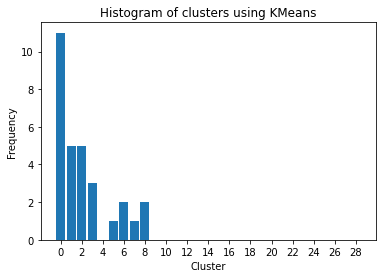

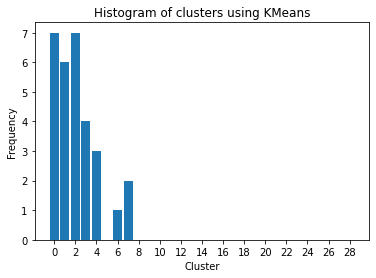

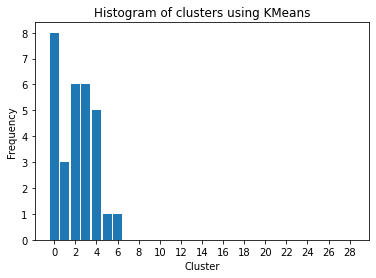

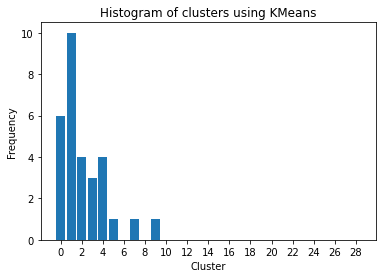

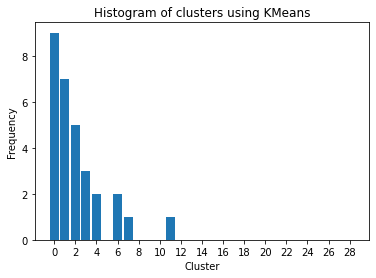

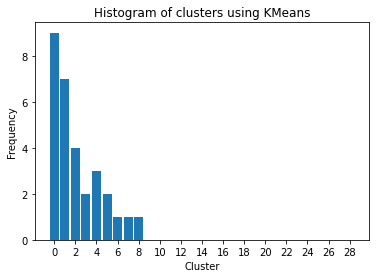

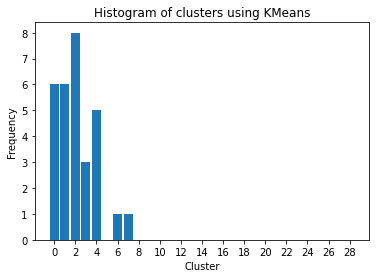

In [ ]:
def plotHistogram(d):
  n, bins, patches = plt.hist(x=d, bins=np.arange(0,30)-0.5, color='tab:blue', rwidth=0.85)
  plt.xticks(range(0, 30, 2))
  plt.xlabel('Cluster')
  plt.ylabel('Frequency')
  plt.title('Histogram of clusters using KMeans')
  plt.show()

for histogram in histograms[:10]:
  plotHistogram(histogram)


# Creating Classification Model

*   The next step is to create a classification model. We will use a C-Support Vector Classification for creating the model.



In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

*   Use GridSearchCV to find the optimal value of C and Gamma.

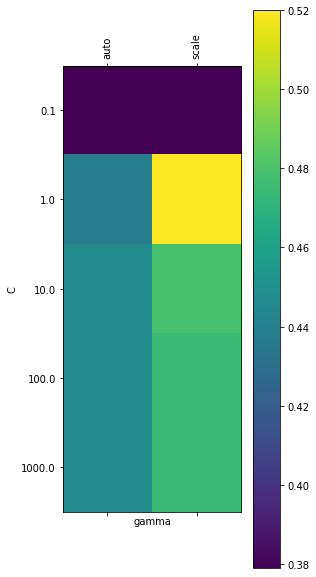


Best combination of parameters found:  {'C': 1.0, 'gamma': 'scale'}

Acc. 10-fold cross on train data=  0.5201298701298702


In [ ]:
gammas = ['auto','scale']
Cs = np.logspace(-1, 3, num=5, base=10.0)

param_grid = {'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(SVC(random_state=random_state), param_grid, cv=10)
grid_search.fit(histograms,y_train)
parval=grid_search.best_params_

scores = grid_search.cv_results_['mean_test_score']
scores = np.array(scores).reshape(len(param_grid['C']), len(param_grid['gamma']))

plt.matshow(scores)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['gamma'])), param_grid['gamma'],rotation='vertical')
plt.yticks(np.arange(len(param_grid['C'])), param_grid['C'])
plt.show()
parval=grid_search.best_params_
print("\nBest combination of parameters found: ",parval)

cvacc = cross_val_score(SVC(C=parval['C'], gamma=parval['gamma'], random_state=random_state) , X=histograms,  y=y_train, cv=10, scoring='accuracy')
print('\nAcc. 10-fold cross on train data= ', cvacc.mean())

We can appreciate that the gamma scale always seems to behave better. The best value is found with C = 1.0 and gamma = scale. Moreover, we can appreciate
that if we keep increasing the C value, the results get worse. We didn't use more values (float values) for gammas because they overfit the system and obtain really bad results with the test dataset. Hence, we decided to choose these as the best parameters for our dataset. As a final note 
We would like to add that we used 10-fold cross-validation, which makes our train accuracy result (~52%) more reliable.

# Testing the Classification Model

*   Extract descriptors using ORB for the test split
*   Use the previously trained k-means to generate the histogram
*   Use the classifier to predict the label


In [ ]:
images_descriptors_test = create_images_descriptors(X_test, descriptor_extractor_64)
descriptors_dataset_test = create_descriptors_dataset(images_descriptors_test)
descriptors_test_pred = kmeans.predict(descriptors_dataset_test)
histograms_test = create_histograms(images_descriptors_test, descriptors_test_pred, numberClasses)

*   Calculate the accuracy score for the classification model

In [ ]:
y_pred = grid_search.predict(histograms_test)
print(f"Accuracy of the classification model using SVC: {accuracy_score(y_test, y_pred)*100}%")

Accuracy of the classification model using SVC: 76.0%


Note that we obtain 76% of accuracy which are quite good results considering that we have 3 classes and the random classification accuracy would be around 33%.

Nevertheless, it is really important to mention that this results may vary a lot depending on the partition made at the start and inicializaton of the methods. For example if the KMeans uses another random_state we had obtained really different results, that can vary from 76% to 54%. This is due to the fact that the dataset is really small and we cannot extract any relevant conclusions as the random seed made the process to obtain really different results.

*   Generate the confusion matrix for the classification model

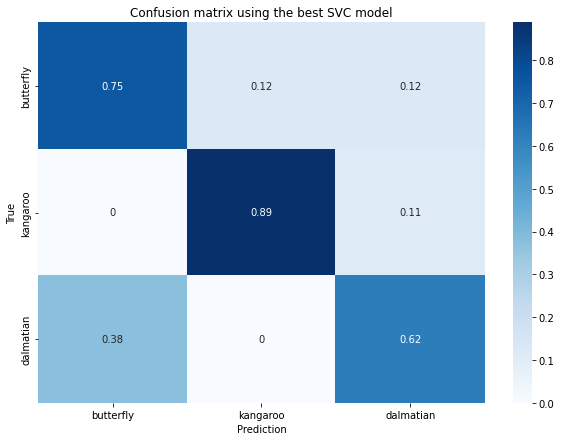

In [ ]:
fig, axs = plt.subplots(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test,y_pred,normalize="true"),annot=True,cmap='Blues',xticklabels=categories,yticklabels=categories)
plt.ylabel("True")
plt.xlabel("Prediction")
plt.title("Confusion matrix using the best SVC model")
plt.show()

In the confusion matrix we can see on the left the ground truth categories and the predicted ones in the columns. We had normalized the values of the rows, i.e. normalize the values for the real classes. We can see that 75% of the butterflies are correctly classified while 25% of them are being considered dalmatians or kangaroos. With the kangaroos it happen that we have a bit more accuracy of 89% because our predictor has decided that only 11% are dalmatians. For the last class, the dalmatians, we found that it finds only 62% of them correctly while considering 38% of the dalmatian images as butterflies.

Regarding the random inicialization, i.e. the determination of the random seed mentioned before, this confusion matrix and its results may change a lot.

*   **Why do we use Clustering to create the codebook?**
> We use clustering in order to create clusters, where the cluster centers are the representatives (codewords) of the descriptors groups we have generated during the clustering. These codewords will be used to classify the descriptors of the different images. For each image, we classify the 64 descriptors into the 30 codewords we have defined above. After This means that each image has the same representation (histogram).Finally, we can use all the histograms generated to train our model. To summarize in one sentence, we use clustering to define 30 codewords to express all the images in the same way.
*   **What are the other techniques that can be used to create the codebook?**

> There are several techniques used for generating the codebooks in order to do image classification. However, they are divided into two categories. There are two types of techniques: supervised and unsupervised. Unsupervised codebook creation groups feature descriptors of any  class together and categorizes the clusters according to the dominant class, whereas supervised codebook generation only groups feature descriptors of the same class together. There are a lot of techniques that can be used to create the codebooks. Some examples are:  Linde Buzo Gray (LBG),  Kekre’s Proportionate Error Algorithm (KPE) and many others. We had extracted this information from this [paper](https://www.researchgate.net/publication252015622_Techniques_for_generating_initial_codebook_for_Vector_Quantization).

# Increased Feature Dimensions

*   Repeat the classification using features of 256 ORB keypoints.

In [ ]:
descriptor_extractor_256 = ORB(n_keypoints=256)
images_descriptors_train_256 = create_images_descriptors(X_train, descriptor_extractor_256)
descriptors_dataset_train_256 = create_descriptors_dataset(images_descriptors_train_256)
kmeans_256 = MiniBatchKMeans(n_clusters=numberClasses,random_state=random_state).fit(descriptors_dataset_train_256)
descriptors_train_pred_256 = kmeans_256.predict(descriptors_dataset_train_256)
histograms_256 = create_histograms(images_descriptors_train_256, descriptors_train_pred_256, numberClasses)

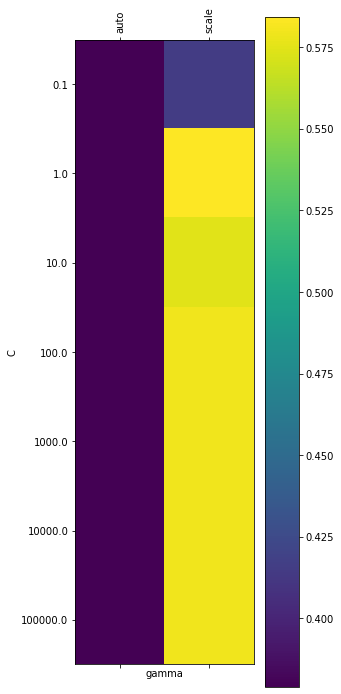


Best combination of parameters found:  {'C': 1.0, 'gamma': 'scale'}

Acc. 10-fold cross on train data=  0.5841991341991342


In [ ]:
gammas = ['auto','scale']
Cs = np.logspace(-1, 5, num=7, base=10.0)

param_grid = {'C': Cs, 'gamma' : gammas}
grid_search_256 = GridSearchCV(SVC(random_state=random_state), param_grid, cv=10)
grid_search_256.fit(histograms_256,y_train)
parval=grid_search_256.best_params_

scores = grid_search_256.cv_results_['mean_test_score']
scores = np.array(scores).reshape(len(param_grid['C']), len(param_grid['gamma']))

plt.matshow(scores)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['gamma'])), param_grid['gamma'],rotation='vertical')
plt.yticks(np.arange(len(param_grid['C'])), param_grid['C'])
plt.show()
parval=grid_search_256.best_params_
print("\nBest combination of parameters found: ",parval)

cvacc = cross_val_score(SVC(C=parval['C'], gamma=parval['gamma'], random_state=random_state) , X=histograms_256,  y=y_train, cv=10, scoring='accuracy')
print('\nAcc. 10-fold cross on train data= ', cvacc.mean())

As before, we can appreciate that the gamma scale always seems to behave better. The best value is found with C = 1.0 and gamma = scale. Hence, we decided to choose these as the best parameters for our dataset. As a final note 
We would like to add that we used 10-fold cross-validation, which makes our train accuracy result (~58%), which is higher than the 52% obtained with 64 descriptors, more reliable.

In [ ]:
images_descriptors_test_256 = create_images_descriptors(X_test, descriptor_extractor_256)
descriptors_dataset_test_256 = create_descriptors_dataset(images_descriptors_test_256)
descriptors_test_pred_256 = kmeans_256.predict(descriptors_dataset_test_256)
histograms_test_256 = create_histograms(images_descriptors_test_256, descriptors_test_pred_256, numberClasses)

In [ ]:
y_pred_256 = grid_search_256.predict(histograms_test_256)
print(f"Accuracy of the classification model using SVC and 256 descriptors: {accuracy_score(y_test, y_pred_256)*100}%")

Accuracy of the classification model using SVC and 256 descriptors: 72.0%


*   **What is the difference in classifier performance between using 64 keypoints and 256 keypoints?**

We had seen that we get worse results for this method using 256 keypoints. We get 72% of accuracy while we obtained 76% for the one with 64 keypoints. This decrement of an absolute 4% is quite important and makes sense considering that as we use more descriptors we may retrieve more information about the images but we will be also maybe overfitting the model with the train dataset and obtaining worse results with the test one. It is also important to mention that we have a really small dataset and it is not feasible to make a validation partition to compare models. 

Nevertheless, again, we have to take into consideration the randomicity of the methods and the split because we have found really different results using different random seeds. We have even seen that the accuracy results were worse using more keypoints for some of the random seeds used. Hence, no much deep conclusions can be extracted from this results and we should be considering a bunch of random seeds and partitions to obtain a reliable accuracy value for each of the models and then extract interesting analysis.


*   **Will further adding more keypoints increase the performance of the algorithm?**

Intuitively, at least for this type of images, there is no need to increase more the number of keypoints. We will arrive to a point where we only retrieve irrelevant or redundant descriptors. Due to this we think that we will not obtain better results with more descriptors. If we keep increasing the number of keypoints, We will need to train a model with more datat that will not be able to adapt to all the cases, and maybe even overfits the results.


---

## **End of P3_2: Image Classification using Bag of Visual Words**
Deadline for P3_2 submission in CampusVirtual is: **Thursday, the 17th of November, 2022**